# Running Monte Carlo over real files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import urllib.request
import json
from   collections import OrderedDict

import astropy.coordinates as coord
import astropy.units as u
from   astropy import time as t

import poliastro
from poliastro.bodies   import Earth
from poliastro.twobody  import Orbit
from poliastro.plotting import plot

import corner

import emcee

# Loading multiple files with a SINGLE satellite

In [2]:
# Integer, reduces x ScaleFactor the number of measurements used to do the MCMC
ScaleFactor = 30 

c = 299792.458  # km/s

def GetDopplerShift(f_c, f_m):
    DS = (f_m - f_c)/f_c
    return DS
    
def get_v_radial(f_c, f_m):
    v_r = c * GetDopplerShift(f_c, f_m)
    return v_r

In [3]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)


raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)
        
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)
    
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])

# Get Doppler Shift data from F_c and F_m

In [4]:
f_c = obj['data'][0]['channel_f_center'] # Central freq. for the satellite

tau = []
DS = []

for i in range(N):
    
    print("Sat ID: {}".format(json_files[i]['data'][0]['sat_id']))
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_DS   = []
    
    
    for s in range(len(stream)):
        if (s % ScaleFactor == 0):
            aux_tau.append( float(stream[s]['time_system']))
            aux_DS.append( GetDopplerShift(f_c, float(stream[s]['f']) ))

    print("Stream length: {}".format(len(aux_DS)))
    tau.append(aux_tau)
    DS.append(aux_DS)
    
M = 0

for i in range(N):
    print(len(tau[i]))
    M += len(tau[i])
    
print('Total number of Measurements M = {}'.format(M))

Sat ID: 1
Stream length: 14
Sat ID: 1
Stream length: 14
Sat ID: 1
Stream length: 13
Sat ID: 1
Stream length: 14
14
14
13
14
Total number of Measurements M = 55


### Doppler Shift measured by Ground Stations

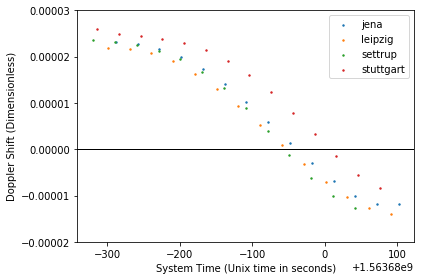

In [5]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], DS[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

In [118]:
Doppler_Uncertainty = 10**(-6)

### Calculating GS positions and velocities in the GeoCentric Reference System

In [7]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [8]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)
    
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In the next cell we calculate the velocity and the position of each ground station at each moment of measurement. It takes around 2 minutes per 400 observations.
%%In this case around 8 minutes per four stations (~1600 observations)

In [9]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-08-26 19:49:52.191152
iteration 0 ends at time 2019-08-26 19:49:57.218978
iteration 1 starts at time 2019-08-26 19:49:57.219452
iteration 1 ends at time 2019-08-26 19:50:00.577113
iteration 2 starts at time 2019-08-26 19:50:00.577580
iteration 2 ends at time 2019-08-26 19:50:03.711164
iteration 3 starts at time 2019-08-26 19:50:03.711623
iteration 3 ends at time 2019-08-26 19:50:07.057606


### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

### Generate the initial positions of Random Walkers

In [10]:
def random_a():
    # from 400 km to 1000 km
    return (Earth.R + (4e5 + 6e5 *np.random.rand())*u.m).value

def random_ecc():
    return np.random.rand()*0.1

def random_inc():
    return 80 + 40*np.random.rand()

def random_raan():
    return np.random.rand()*360

def random_argp():
    return np.random.rand()*360

def random_nu():
    return np.random.rand()*360

# Orbit generated from Classical Parameters

In [11]:
nwalkers = 500
ndim = 6
MCMC_steps = 100

In [12]:
P0 = []

for i in range(nwalkers):
    aux = np.array([random_a(), random_ecc(), random_inc(), 
                    random_raan(), random_argp(), random_nu()])
    P0.append(aux)
    
P0 = np.array(P0)

In [13]:
c = 299792.458 * u.km / u.s

def redshift(f_0, Vradial ):
    
    return f_0 * (1 + Vradial / c)

In [14]:
TestOrbit = Orbit.from_classical(Earth, 
                               P0[0][0]*u.m,
                               P0[0][1]*u.one,
                               P0[0][2]*u.deg,
                               P0[0][3]*u.deg,
                               P0[0][4]*u.deg,
                               P0[0][5]*u.deg,
                               epoch=tau_astropytime[0][0] )

In [15]:
def norm(A_list):
    A = 0
    for a in A_list:
        A += a**2
    return A**0.5

# Likelihood

In [16]:
def lnprob( param ):
    """
    param = [a, ecc, inc, raan, argp, nu]
    """
    a, ecc, inc, raan, argp, nu = param
    
    ### Limit the parameter space ###
    
    if a < Earth.R.value + 300000:
        return -np.inf
    
    if (ecc < 0) or (ecc > 1) :
        return -np.inf
    
    if (inc < 80) or (inc > 120):
        return -np.inf
    
    if abs(raan) > 360:
        return -np.inf
    
    if abs(nu) > 180:
        return -np.inf
    
    a    =   a  * u.m
    ecc  = ecc  * u.one
    inc  = inc  * u.degree
    raan = raan * u.deg
    argp = argp * u.deg
    nu   = nu   * u.deg
    
    tau_0 = tau_astropytime[0][0]

    myOrbit = Orbit.from_classical(Earth, 
                                 a=a, ecc=ecc, inc=inc, 
                                 raan=raan, argp=argp, nu=nu, epoch=tau_0)
    

    chi2 = 0
    for i in range(N):
        for j in range(len(tau_astropytime[i])):
            chi_aux = 0
            
            t_prime = tau_astropytime[i][j]
            DeltaT = t_prime - tau_0
            
            orbit_at_t_prime = myOrbit.propagate(DeltaT)
                        
            r_sat = orbit_at_t_prime.state.r
            v_sat = orbit_at_t_prime.state.v
            
            r_gs  = GS_gcrs_positions[i][j].get_xyz()
            v_gs  = GS_gcrs_velocities[i][j].get_xyz()

            
            r      = r_sat - r_gs
            r_unit =  r / norm(r)
            v      = v_sat - v_gs
            
            ds_mcmc = v.dot(-r_unit)/c
            ds_mcmc = ds_mcmc.value
            ds_obs  = DS[i][j]
            
            chi_aux = -0.5 * ((ds_mcmc - ds_obs) / Doppler_Uncertainty )**2 / (M - 6)
            
            #print( 'Chi2 {:03.8f} measured {:03.8f} mcmcm {:03.8f} '.format(chi_aux, ds_obs, ds_mcmc) )
            
            
            chi2 += chi_aux

    #print("Chi2 = {}".format(chi2))
    return chi2

In [17]:
for i in range(5):
    lnprob(P0[i])

In [18]:
emcee.__version__

'2.2.1'

In [19]:
t_mcmc_start = t.Time.now()

print(" MCMC running with {} walkers, {} Steps. Starts at t={}".format(nwalkers, MCMC_steps, t_mcmc_start))

 MCMC running with 500 walkers, 100 Steps. Starts at t=2019-08-26 19:50:10.330816


In [20]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

pos, prob, state = sampler.run_mcmc(P0, MCMC_steps)

/home/filipo/anaconda3/envs/env_name/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning:

invalid value encountered in subtract

/home/filipo/anaconda3/envs/env_name/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning:

invalid value encountered in greater



# Now, run the MCMC

In [21]:
t_mcmc_end = t.Time.now()
print(" MCMC running ends at t={}".format( t_mcmc_end))

DeltaT_mcmc = (t_mcmc_end - t_mcmc_start)
print("{} seconds".format(DeltaT_mcmc.sec))

 MCMC running ends at t=2019-08-27 00:29:18.236975
16747.90615900001 seconds


In [22]:
2000/60

33.333333333333336

In [23]:
samples = sampler.chain[:,0:,:].reshape((-1, ndim))


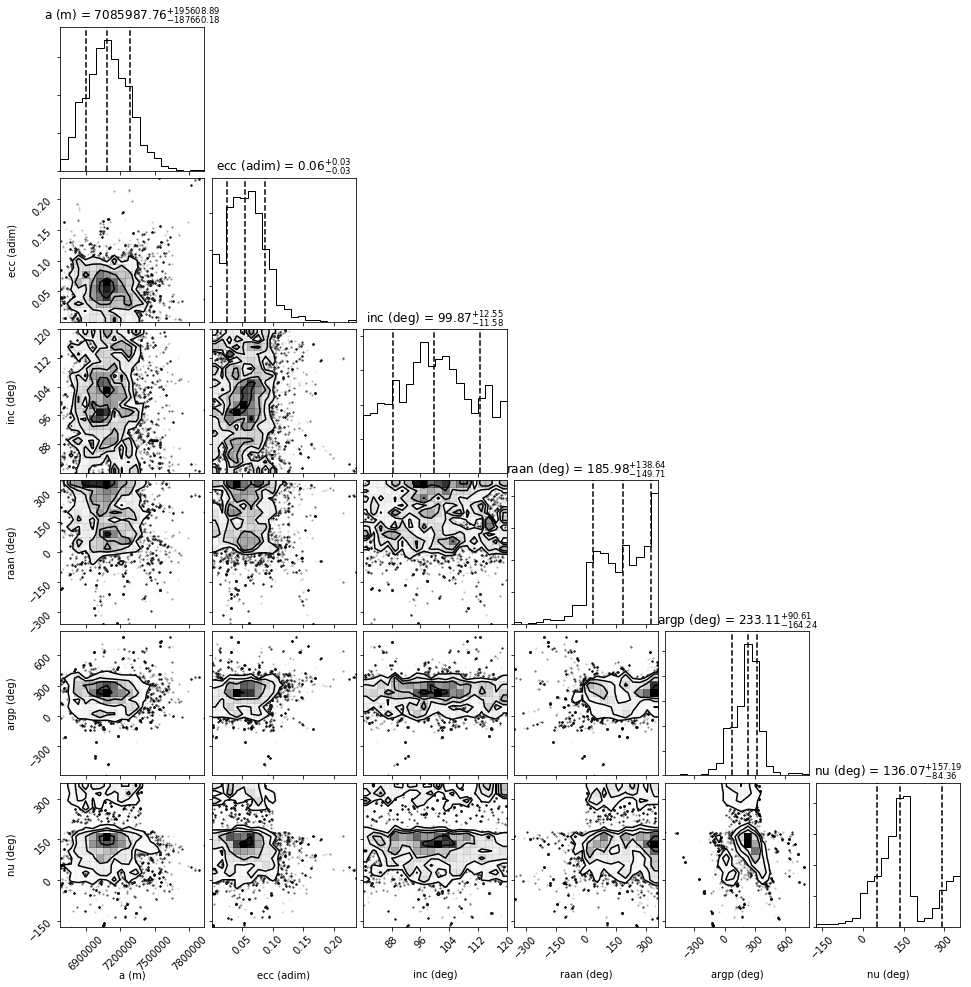

In [24]:
fig = corner.corner(samples, labels=["a (m)", "ecc (adim)", "inc (deg)",
                                     "raan (deg)", "argp (deg)", "nu (deg)"]
                    , show_titles=True
                    , plot_datapoints=True
                    , quantiles=[0.16,0.5, 0.84])

In [25]:
prob = sampler.lnprobability.ravel()

In [26]:
prob

array([-3138.72574425, -3138.72574425, -3138.72574425, ...,
       -5836.69322934, -5836.69322934, -5836.69322934])

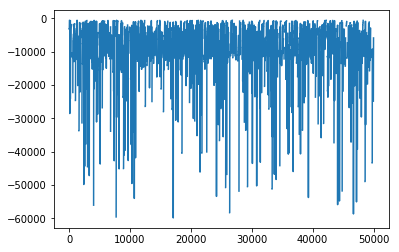

In [27]:
plt.(prob)

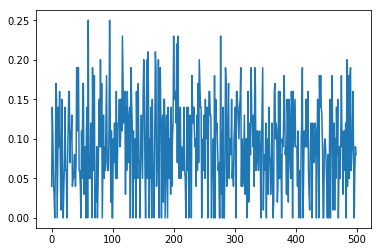

In [28]:
plt.plot(sampler.acceptance_fraction)

In [29]:
a_m  = samples[:,0].mean() 
ecc_m  = samples[:,1].mean() 
inc_m  = samples[:,2].mean() 
raan_m = samples[:,3].mean() 
argp_m = samples[:,4].mean() 
nu_m = samples[:,5].mean() 

In [30]:
print("a\t",(a_m * u.m).to(u.km))
print("ecc\t", (ecc_m*u.one))
print("inc\t", (inc_m*u.deg))
print("raan\t", (raan_m*u.deg))
print("argp\t", (argp_m*u.deg))
print("nu\t", (nu_m*u.deg))


a	 7094.951175080372 km
ecc	 0.056802239588348215
inc	 100.08376887338744 deg
raan	 172.82798341661234 deg
argp	 211.27249933584483 deg
nu	 146.86030065315288 deg


In [31]:
((a_m - Earth.R.value)*u.m).to(u.km)

<Quantity 716.81457508 km>

In [119]:
def plot_mcmc_orbit_dopplershift(param):
    """
    param = [a, ecc, inc, raan, argp, nu]
    """
    a, ecc, inc, raan, argp, nu = param

    a    =   a  * u.m
    ecc  = ecc  * u.one
    inc  = inc  * u.degree
    raan = raan * u.deg
    argp = argp * u.deg
    nu   = nu   * u.deg
    
    tau_0 = tau_astropytime[0][0]

    myOrbit = Orbit.from_classical(Earth, 
                                 a=a, ecc=ecc, inc=inc, 
                                 raan=raan, argp=argp, nu=nu, epoch=tau_0)
    
    
    mcmc_dopplershift = []
    chi2 = 0
    
    for i in range(N):
        
        doppler_aux = []
        
        for j in range(len(tau_astropytime[i])):
            
            chi_aux = 0
            
            t_prime = tau_astropytime[i][j]
            DeltaT = t_prime - tau_0
            
            orbit_at_t_prime = myOrbit.propagate(DeltaT)
                        
            r_sat = orbit_at_t_prime.state.r
            v_sat = orbit_at_t_prime.state.v
            
            r_gs  = GS_gcrs_positions[i][j].get_xyz()
            v_gs  = GS_gcrs_velocities[i][j].get_xyz()
            
            
            r      = r_sat - r_gs
            r_unit =  r / norm(r)
            v      = v_sat - v_gs
            
            
            
            ds_mcmc = v.dot(-r_unit)/c
            ds_mcmc = ds_mcmc.value
            ds_obs  = DS[i][j]
            
            print(norm(r), ds_mcmc)
            
            chi_aux = -0.5 * ((ds_mcmc - ds_obs) / Doppler_Uncertainty )**2 / (M - 6)
            chi2 += chi_aux
    
            doppler_aux.append(ds_mcmc) 
        
        mcmc_dopplershift.append(doppler_aux)
    
    print("Chi2 = ", chi2)
    
    fig = plt.figure(figsize=(6,4))
    plt.axhline(0, c="k", lw=1)

    for i in range(N):
        label = gs_geodetic_locs[i]['gs_name']
        plt.scatter(tau[i], DS[i], s=10, label=label)

    for i in range(N):
        plt.plot(tau[i], mcmc_dopplershift[i])
        
    plt.ylim(-2e-5,3e-5)
    plt.xlabel("System Time (Unix time in seconds)")
    plt.ylabel("Doppler Shift (Dimensionless)")
    plt.legend(loc=0)

    plt.tight_layout()
    #plt.savefig("first_test/measured_doppler_shift.png")

In [120]:
param_test = [a_m, ecc_m, inc_m, raan_m, argp_m, nu_m]

12538.502161692484 km 8.551295918923292e-06
12460.16301117042 km 8.869046058690566e-06
12378.977152060517 km 9.184334078444259e-06
12294.966772102935 km 9.497150775412154e-06
12208.154136888803 km 9.80748735362016e-06
12118.56158755051 km 1.0115335947420577e-05
12026.211540578106 km 1.0420687667550863e-05
11931.12648775859 km 1.0723534492277607e-05
11833.32899725596 km 1.1023866778741322e-05
11732.841715677867 km 1.1321677741889402e-05
11629.687371638216 km 1.1616956431267058e-05
11523.888779216986 km 1.1909693853028543e-05
11415.468843356479 km 1.2199878651557723e-05
11304.450565670932 km 1.2487501096326899e-05
12566.508885904139 km 8.434172111156772e-06
12489.219072081216 km 8.75282337637389e-06
12409.074433969916 km 9.069015146842459e-06
12326.097130502723 km 9.382738823530576e-06
12240.309398690315 km 9.693985827602104e-06
12151.733552384883 km 1.0002747554248987e-05
12060.391980430672 km 1.0309015535430727e-05
11966.307146803842 km 1.0612781768630064e-05
11869.501591326874 km 1.09

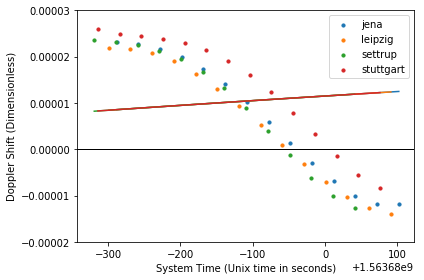

In [121]:
plot_mcmc_orbit_dopplershift(param_test)

In [122]:
np.where(sampler.lnprobability == sampler.lnprobability.max())

(array([77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
        77]),
 array([82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
        99]))

In [123]:
sampler.lnprobability[77][87]

-525.5168540511156

In [124]:
sampler.chain[77][87]

array([6.96705082e+06, 8.04984082e-02, 9.81799008e+01, 3.53027562e+02,
       3.80490826e+02, 1.02502208e+01])

2518.2916948116876 km 2.1858160955553132e-05
2325.461992063473 km 2.0983856065152806e-05
2141.638931988282 km 1.9843654346628517e-05
1969.5554147026908 km 1.835859394144223e-05
1812.7323520342022 km 1.643311535498354e-05
1675.5914013846557 km 1.39654196700806e-05
1563.4001164028573 km 1.0875895719405945e-05
1481.8556124635911 km 7.1589159429824725e-06
1436.1421085037305 km 2.9426311635657177e-06
1429.590132278125 km -1.4925422765570617e-06
1462.5555909098305 km -5.784919643102178e-06
1532.2694765306503 km -9.6231612651012e-06
1633.774509461375 km -1.284001435436644e-05
1761.2938226652311 km -1.5414071384045354e-05
2590.820457559771 km 2.212475184881471e-05
2395.243667489507 km 2.1331700516291814e-05
2207.8376225487305 km 2.0297198890884528e-05
2031.0857458507403 km 1.894889775785958e-05
1868.202693249416 km 1.7196782566306786e-05
1723.2737791384388 km 1.4939198957330446e-05
1601.2809143844333 km 1.208360313976958e-05
1507.8435955821024 km 8.589999480906877e-06
1448.4770146829273 km 4.5

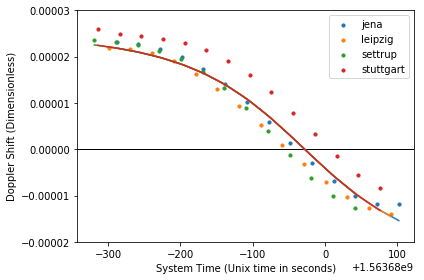

In [125]:
plot_mcmc_orbit_dopplershift(sampler.chain[77][87])

In [50]:
lnprob(sampler.chain[77][87])

-525.5168540511156

In [51]:
testOrbit = Orbit.from_classical(Earth,
                                6.96705082e+06 * u.m, 
                                 8.04984082e-02 * u.one, 
                                 9.81799008e+01 * u.deg, 
                                 3.53027562e+02 * u.deg,
                                 3.80490826e+02 * u.deg, 
                                 1.02502208e+01 * u.deg,
                                tau_astropytime[0][0])

In [56]:
testOrbit.state.a - Earth.R

<Quantity 588914.22 m>

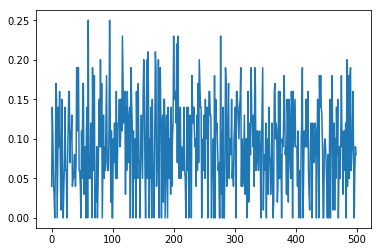

In [59]:
plt.plot(sampler.acceptance_fraction)

In [60]:
!mkdir mcmc_run_500walkers_100steps


In [64]:
filepath = "mcmc_run_500walkers_100steps/"


In [83]:
np.save(filepath + "chain.dat", sampler.chain.shape)

In [84]:
np.save(filepath + "lnprobability.dat", sampler.lnprobability)

Chi2 =  -599.3186580240811


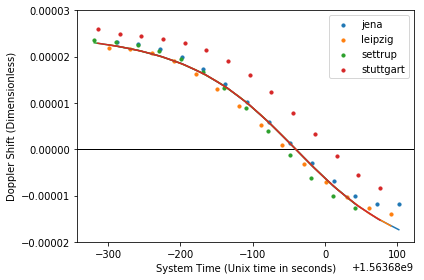

In [94]:
plot_mcmc_orbit_dopplershift(np.array([6.1309182e+06, 0.01, 9.81799008e+01, 3.53027562e+02,
       3.80490826e+02, 1.02502208e+01]))

Chi2 =  -1769.7082652552183


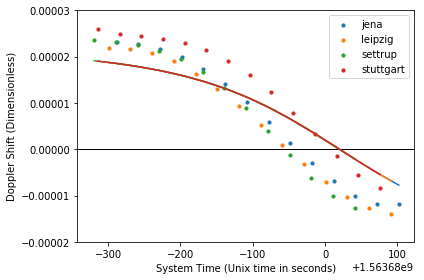

In [95]:
plot_mcmc_orbit_dopplershift(np.array([7.1309182e+06, 0.01, 9.81799008e+01, 3.53027562e+02,
       3.80490826e+02, 1.02502208e+01]))

Chi2 =  -525.5168568096436


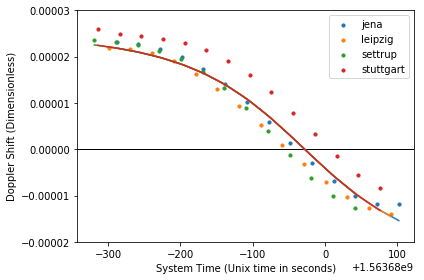

In [96]:
plot_mcmc_orbit_dopplershift(np.array([6.96705082e+06, 8.04984082e-02, 9.81799008e+01, 3.53027562e+02,
       3.80490826e+02, 1.02502208e+01]))